<a href="https://colab.research.google.com/github/mittwoch09/section_02/blob/main/AI_08_%EC%9E%A5%EC%84%B8%EC%A4%80_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import shap

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Regression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Modelling Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Validation
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from google.colab import files
uploaded = files.upload()

Saving diamonds.csv to diamonds (3).csv


In [4]:
df = pd.read_csv('diamonds.csv')

df

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


# Features
- Carat : 다이아몬드의 중량
- Cut : 다이아몬드의 연마상태
- Color : 다이아몬드의 색이 얼마나 무색(Colorless)에 가까운가를 결정
  - D, E, F / G, H, I, J 순서
- Clarity : 다이아몬드의 투명도(내포물과 외부의 흠으로 구분된다.)
 - FL, IF /  VVS1, VVS2 / VS1, VS2 / SI1, SI2 / I1, I2, I3 순서
- Depth : 다이아몬의 깊이 비율
- Table : 다이아몬드의 팔각형 윗면의 직경 비율
- Price : 다이아몬드의 가격
- X : 다이아몬드의 길이(mm 단위)
- Y : 다이아몬드의 폭(mm 단위)
- Z : 다이아몬드의 높이(mm 단위)

Categorical : Cut, Color, Clarity.

Numerical : Carat, Depth, Table ,Price ,X ,Y, Z.

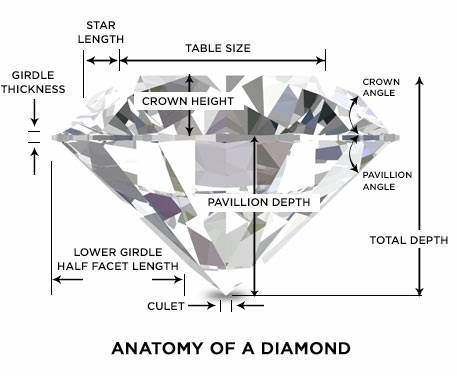

##EDA

In [5]:
# categorical fetures 확인

df['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [6]:
df['color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [7]:
df['clarity'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [8]:
# 불필요한 'Unnamed: 0' 칼럼 제거

df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [9]:
df.shape

(53940, 10)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [11]:
# 중복 데이터 확인

df.duplicated().sum()

146

In [12]:
df.loc[df.duplicated(), :]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


In [13]:
# 중복 데이터 제거

df.drop_duplicates(inplace=True)

In [14]:
df.shape

(53794, 10)

In [15]:
df.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [16]:
# x(길이), y(폭), z(높이)가 각각 0인 값들이 존재

df.loc[(df['x']==0) | (df['y']==0) | (df['z']==0)]

,carat,cut,color,clarity,depth,table,price,x,y,z
2207,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2314,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4791,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5471,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10167,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11963,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13601,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15951,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24394,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


In [17]:
len(df.loc[(df['x']==0) | (df['y']==0) | (df['z']==0)])

19

In [18]:
# 19개의 row에 치수가 '0'인 다이아몬드가 존재
# drop하여 위 값들을 제거한다

df = df[(df[['x','y','z']] != 0).all(axis=1)]

In [19]:
df.shape

(53775, 10)

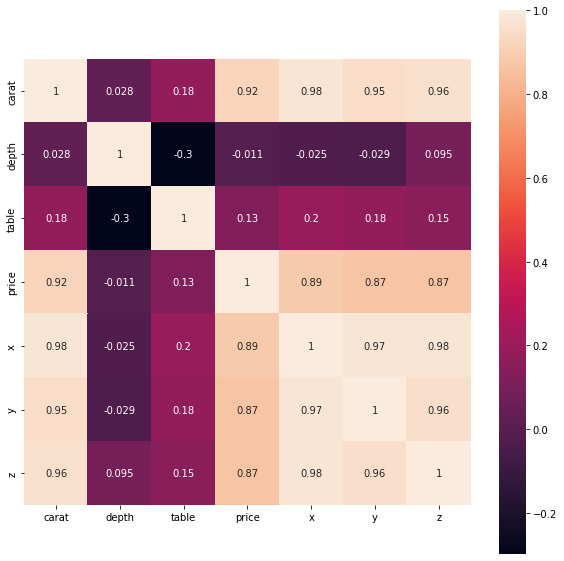

In [20]:
corr = df.corr()

plt.figure(figsize = (10,10))
sns.heatmap(data=corr, square=True, annot=True, cbar=True);

### carat은 price와 연관성이 상당히 높다. 
### x,y,z와 price는 연관성이 높은데 비해, depth와 table은 pirce와의 연관성이 낮다.

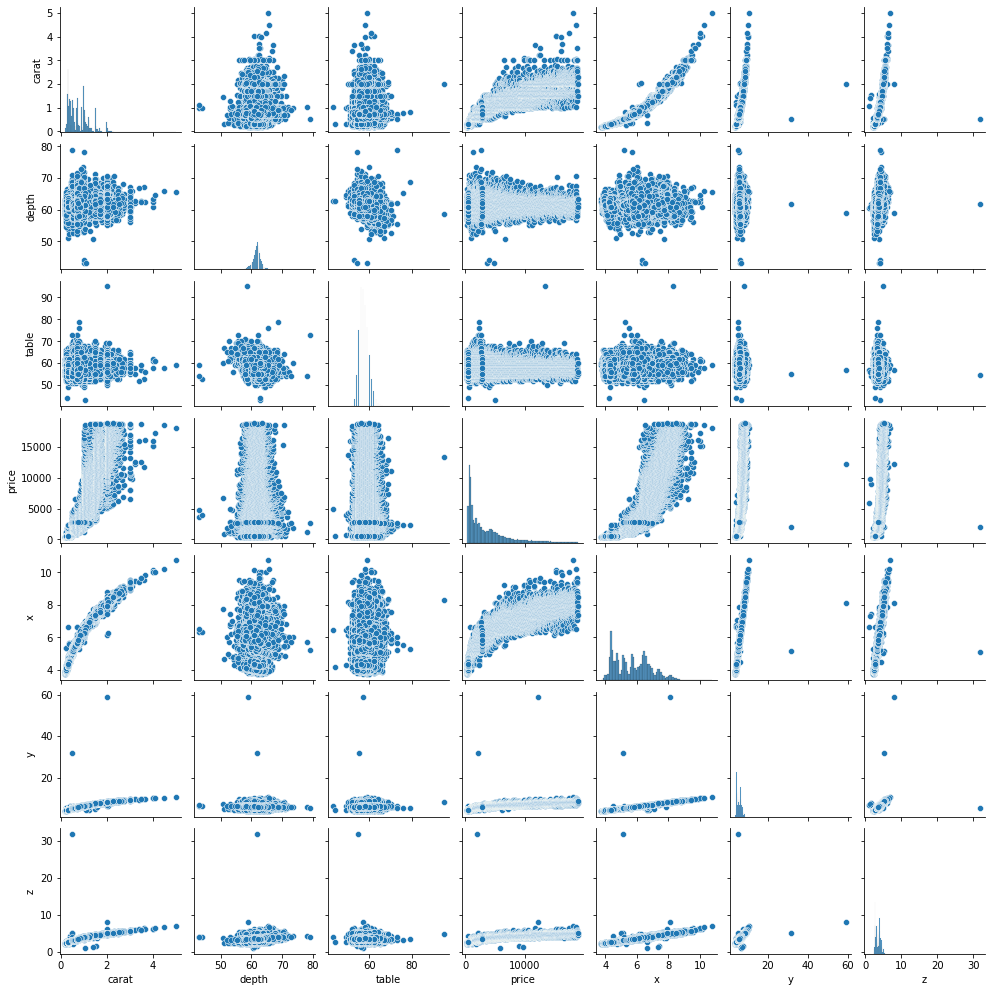

In [21]:
sns.pairplot(df, height=2);

### Carat

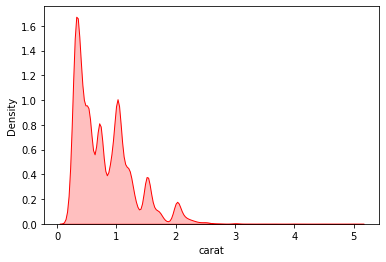

In [22]:
# 'carat'의 분포 확인
import seaborn as sns
sns.kdeplot(df['carat'], shade=True , color='r');

### Cut

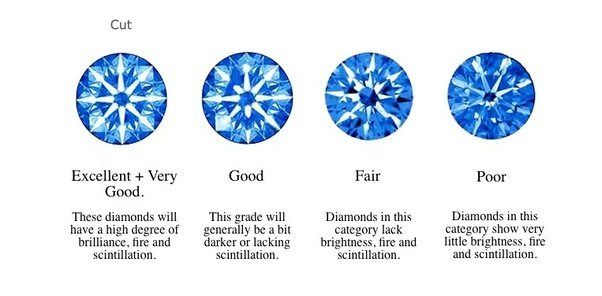

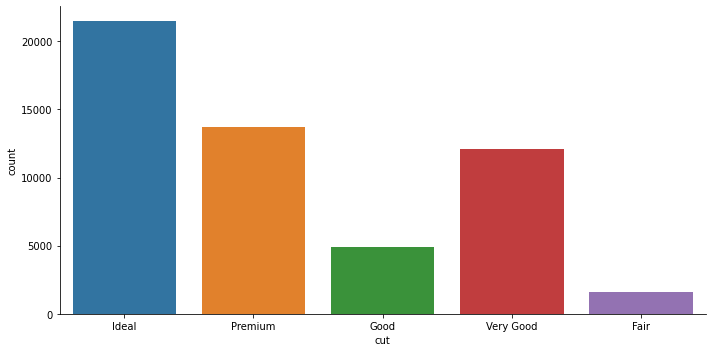

In [23]:
# 'cut'의 분포 확인

sns.catplot(x='cut', data=df , kind='count',aspect=2);

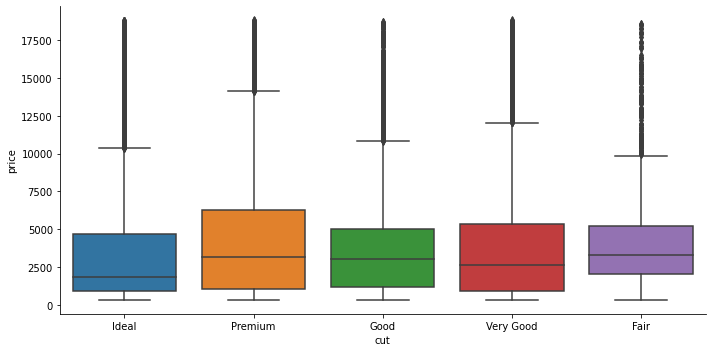

In [24]:
# 'cut'과 'price'의 관계 확인

sns.catplot(x='cut', y='price', data=df, kind='box' ,aspect=2);

### Color

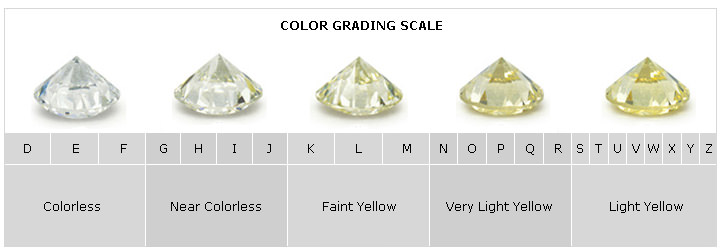

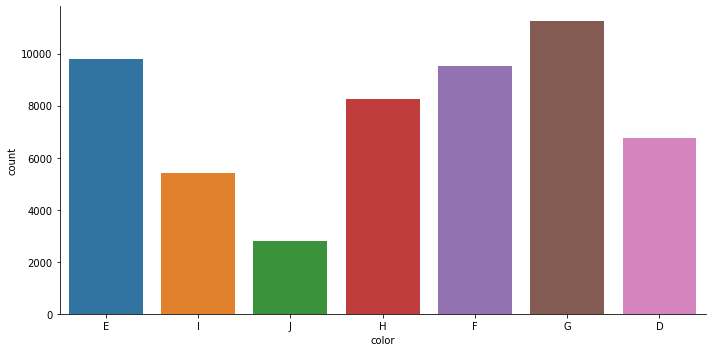

In [25]:
# 'color'의 분포 확인

sns.catplot(x='color', data=df , kind='count',aspect=2);

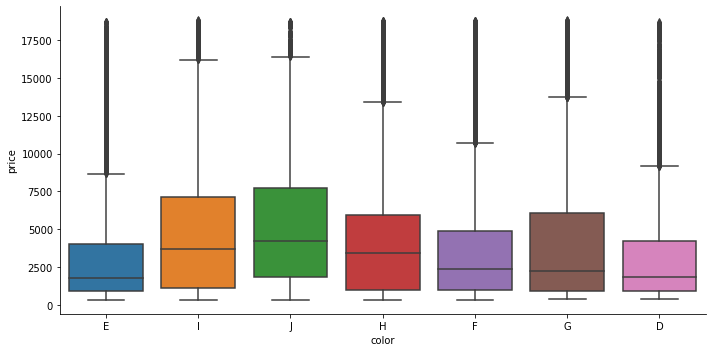

In [26]:
# 'color'와 'price'의 관계 확인

sns.catplot(x='color', y='price', data=df, kind='box' ,aspect=2);

### Clarity

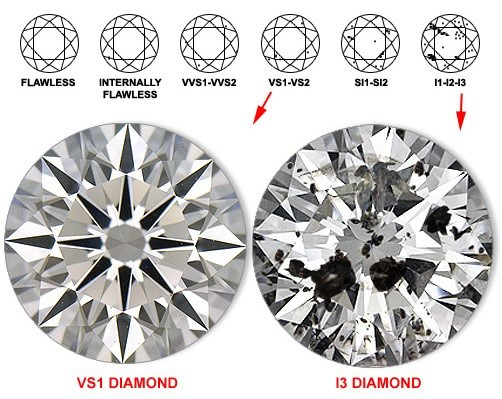

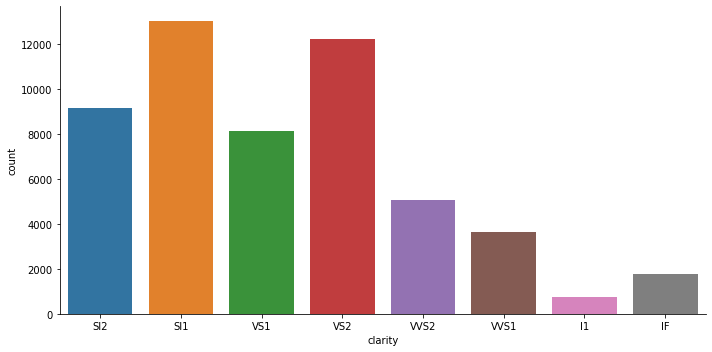

In [27]:
# 'clarity'의 분포 확인

sns.catplot(x='clarity', data=df , kind='count',aspect=2);

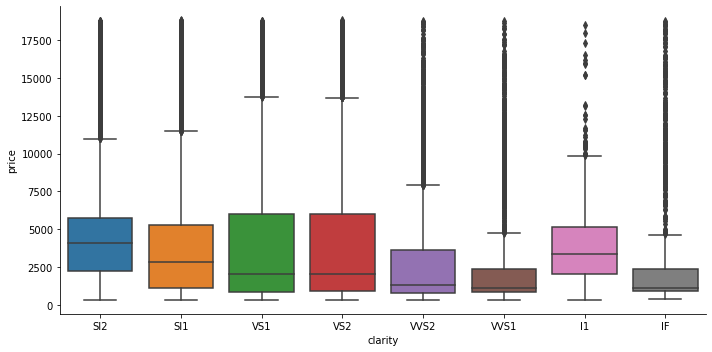

In [28]:
# 'clarity'와 'price'의 관계 확인

sns.catplot(x='clarity', y='price', data=df, kind='box' ,aspect=2);

### Depth

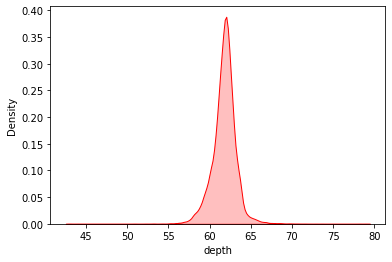

In [29]:
sns.kdeplot(df['depth'], shade=True , color='r');

### Table 

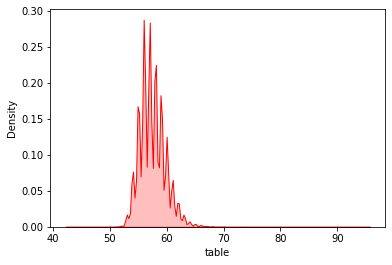

In [30]:
sns.kdeplot(df['table'], shade=True , color='r');

### Dimensions(x, y, z)

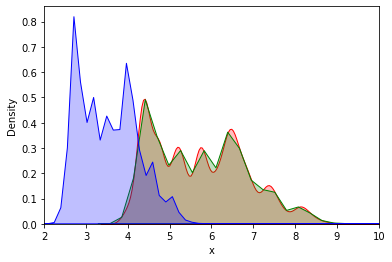

In [31]:
import matplotlib.pyplot as plt

sns.kdeplot(df['x'] ,shade=True , color='r')
sns.kdeplot(df['y'] , shade=True , color='g')
sns.kdeplot(df['z'] , shade= True , color='b')
plt.xlim(2, 10);

## Feature Engineering

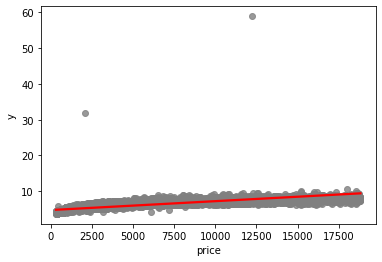

In [32]:
# outlier 확인

sns.regplot(x = df['price'], y = df['y'], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'});

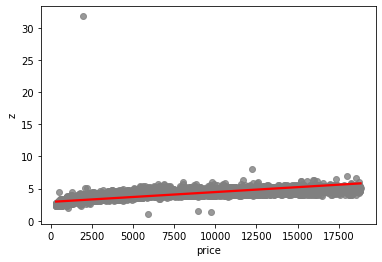

In [33]:
sns.regplot(x = df['price'], y = df['z'], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'});

In [34]:
df.sort_values(by='z', ascending=True)

,carat,cut,color,clarity,depth,table,price,x,y,z
14635,1.07,Ideal,F,SI1,60.6,57.0,5909,6.62,6.67,1.07
21654,1.41,Ideal,H,VS1,60.7,56.0,9752,7.31,7.22,1.41
20694,1.53,Ideal,I,SI1,61.9,54.0,8971,7.43,7.50,1.53
39246,0.38,Ideal,E,VVS2,60.9,56.0,1068,4.71,4.68,2.06
31592,0.20,Premium,E,VS2,59.0,60.0,367,3.81,3.78,2.24
...,...,...,...,...,...,...,...,...,...,...
27130,4.13,Fair,H,I1,64.8,61.0,17329,10.00,9.85,6.43
27630,4.50,Fair,J,I1,65.8,58.0,18531,10.23,10.16,6.72
27415,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06


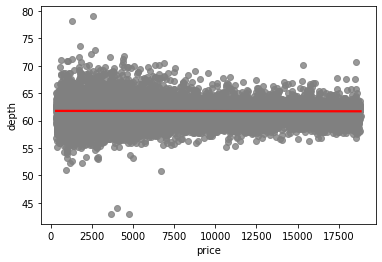

In [35]:
sns.regplot(x = df['price'], y = df['depth'], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'});

In [36]:
df.sort_values(by='depth', ascending=True)

,carat,cut,color,clarity,depth,table,price,x,y,z
10377,1.09,Ideal,J,VS2,43.0,54.0,4778,6.53,6.55,4.12
4518,1.00,Fair,G,SI1,43.0,59.0,3634,6.32,6.27,3.97
6341,1.00,Fair,G,VS2,44.0,53.0,4032,6.31,6.24,4.12
16857,1.43,Fair,I,VS1,50.8,60.0,6727,7.73,7.25,3.93
36503,0.30,Fair,E,VVS2,51.0,67.0,945,4.67,4.62,2.37
...,...,...,...,...,...,...,...,...,...,...
51928,0.96,Fair,G,SI2,72.2,56.0,2438,6.01,5.81,4.28
53540,0.90,Fair,G,SI1,72.9,54.0,2691,5.74,5.67,4.16
46679,0.99,Fair,J,I1,73.6,60.0,1789,6.01,5.80,4.35
41918,1.03,Fair,E,I1,78.2,54.0,1262,5.72,5.59,4.42


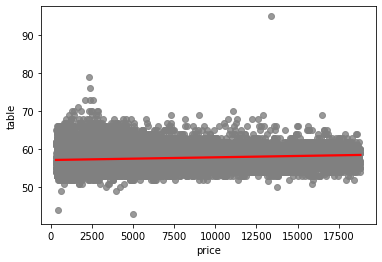

In [37]:
sns.regplot(x = df['price'], y = df['table'], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'});

In [38]:
df.sort_values(by='table', ascending=True)

,carat,cut,color,clarity,depth,table,price,x,y,z
11368,1.04,Ideal,I,VS1,62.9,43.0,4997,6.45,6.41,4.04
35633,0.29,Very Good,E,VS1,62.8,44.0,474,4.20,4.24,2.65
22701,0.30,Fair,E,SI1,64.5,49.0,630,4.28,4.25,2.75
5979,1.00,Fair,I,VS1,64.0,49.0,3951,6.43,6.39,4.10
7418,1.02,Fair,F,SI1,61.8,50.0,4227,6.59,6.51,4.05
...,...,...,...,...,...,...,...,...,...,...
51391,0.71,Fair,D,VS2,55.6,73.0,2368,6.01,5.96,3.33
52860,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09
51342,0.79,Fair,G,SI1,65.3,76.0,2362,5.52,5.13,3.35
50773,0.81,Fair,F,SI2,68.8,79.0,2301,5.26,5.20,3.58


In [39]:
# outlier를 제거

df = df[(df['y'] < 30)]
df = df[(df['z'] < 30) & (df['z'] > 2)]
df = df[(df['depth'] > 45)]
df = df[(df['table'] < 80)]

In [40]:
df.shape

(53765, 10)

In [41]:
# 길이, 폭, 높이를 반영한 volume 칼럼 생성

df['volume'] = df['x']*df['y']*df['z']
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250


In [71]:
df.shape

(53765, 11)

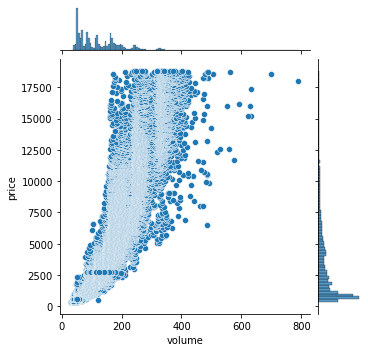

In [43]:
sns.jointplot(x='volume', y='price' , data=df, height=5);

## Featrue Encoding

In [44]:
# categorical feature 인 cut/color/clarity 인코딩 필요

label_cut = LabelEncoder()
label_color = LabelEncoder()
label_clarity = LabelEncoder()


df['cut'] = label_cut.fit_transform(df['cut'])
df['color'] = label_color.fit_transform(df['color'])
df['clarity'] = label_clarity.fit_transform(df['clarity'])

In [45]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75,51.917250


## Feature Scaling

In [46]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [47]:
X_train.shape, X_test.shape

((43012, 10), (10753, 10))

In [48]:
cols = X_train.columns

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

In [49]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,volume
0,-0.015763,-0.539090,0.825772,1.834977,0.458262,-0.656688,0.159900,0.186381,0.232389,0.001562
1,-1.050723,0.435045,-1.524630,-1.062625,0.599892,-0.656688,-1.288246,-1.344402,-1.258346,-1.062734
2,-1.050723,-0.539090,-0.937029,1.255457,0.245817,-0.205968,-1.306124,-1.290375,-1.272820,-1.059147
3,0.216575,-1.513226,-0.349429,-0.483104,1.024781,-0.205968,0.320805,0.375478,0.478433,0.198589
4,-0.923993,0.435045,-0.349429,0.675936,-0.887221,0.695473,-1.002192,-0.984218,-1.070195,-0.914497


## Modling & Validation
### Linear Regression (Baseline Model)

In [50]:
model_lr = LinearRegression()
model_lr.fit(X_train , y_train)

accuracies = cross_val_score(estimator = model_lr, X = X_train, y = y_train, cv = 5)
y_pred = model_lr.predict(X_test)

print('')
print('####### Linear Regression #######')
print('Score : %.4f' % model_lr.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)


####### Linear Regression #######
Score : 0.8902
[0.88556053 0.88425522 0.89015294 0.88930034 0.89121918]

MSE    : 1720111.57 
MAE    : 837.81 
RMSE   : 1311.53 
R2     : 0.89 


### Ridge Regression

In [51]:
model_rr = Ridge(normalize=True)
model_rr.fit(X_train , y_train)

accuracies = cross_val_score(estimator = model_rr, X = X_train, y = y_train, cv = 5)
y_pred = model_rr.predict(X_test)

print('')
print('####### Ridge Regression #######')
print('Score : %.4f' % model_rr.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)


####### Ridge Regression #######
Score : 0.8174
[0.81244492 0.81603704 0.81805196 0.81379689 0.81304546]

MSE    : 2859944.82 
MAE    : 1096.81 
RMSE   : 1691.14 
R2     : 0.82 


### GradientBoosting Regression

In [52]:
model_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
model_gbr.fit(X_train , y_train)

accuracies = cross_val_score(estimator = model_gbr, X = X_train, y = y_train, cv = 5)
y_pred = model_gbr.predict(X_test)

print('')
print('####### GradientBoosting Regression #######')
print('Score : %.4f' % model_gbr.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)


####### GradientBoosting Regression #######
Score : 0.9058
[0.9067924  0.90511855 0.90924708 0.90700336 0.90666336]

MSE    : 1476505.89 
MAE    : 711.59 
RMSE   : 1215.12 
R2     : 0.91 


##XGB Regression

In [53]:
model_xgbr = XGBRegressor( n_estimators=1000, objective='reg:squarederror', learning_rate=0.2, n_jobs=-1)
model_xgbr.fit(X_train , y_train)

accuracies = cross_val_score(estimator = model_xgbr, X = X_train, y = y_train, cv = 5)
y_pred = model_xgbr.predict(X_test)

print('')
print('####### XGB Regression #######')
print('Score : %.4f' % model_xgbr.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)


####### XGB Regression #######
Score : 0.9815
[0.97915928 0.9803623  0.97860674 0.98068131 0.98067256]

MSE    : 289534.43 
MAE    : 281.21 
RMSE   : 538.08 
R2     : 0.98 


## RandomForest Regression

In [54]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train , y_train)

accuracies = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv = 5)
y_pred = model_rf.predict(X_test)

print('')
print('####### RandomForest Regression #######')
print('Score : %.4f' % model_rf.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)


####### RandomForest Regression #######
Score : 0.9814
[0.98049663 0.98158626 0.97964506 0.98095234 0.98096838]

MSE    : 291752.70 
MAE    : 263.36 
RMSE   : 540.14 
R2     : 0.98 


## Hyperparameter Tuning

In [55]:
n_estimators = [int(x) for x in np.linspace(10,200,10)]
max_depth = [int(x) for x in np.linspace(10,100,10)]
min_samples_split = [2,3,4,5,10]
min_samples_leaf = [1,2,4,10,15,20]
random_grid = {'n_estimators':n_estimators,'max_depth':max_depth,
               'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

random_grid

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_leaf': [1, 2, 4, 10, 15, 20],
 'min_samples_split': [2, 3, 4, 5, 10],
 'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

In [56]:
model_rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=model_rf,
                               param_distributions=random_grid,
                               cv = 3)

rf_random.fit(X_train,y_train)
y_pred = rf_random.predict(X_test)

print('')
print('####### RandomForest Regression with RandomizedSearch CV #######')

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)


####### RandomForest Regression with RandomizedSearch CV #######

MSE    : 286460.22 
MAE    : 260.96 
RMSE   : 535.22 
R2     : 0.98 


## SHAP

In [57]:
explainer = shap.TreeExplainer(model_xgbr)
shap_values = explainer.shap_values(X_test)

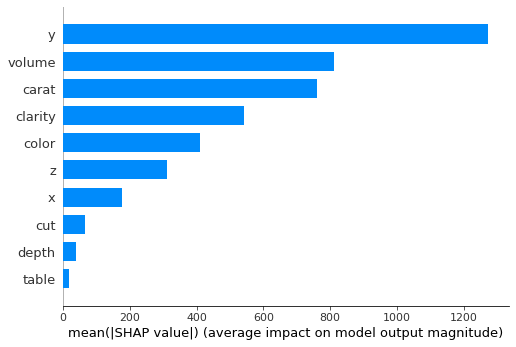

In [70]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

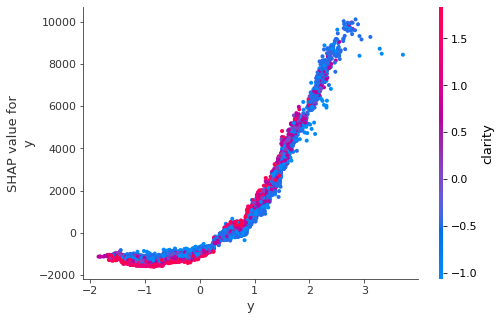

In [66]:
shap.dependence_plot("y", shap_values, X_test, feature_names=X_test.columns);

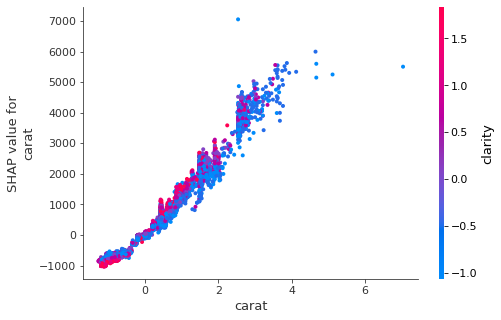

In [67]:
shap.dependence_plot("carat", shap_values, X_test, feature_names=X_test.columns);